# Parking_loc

基于停车场采集的真实数据测试hloc算法。

## 建图

### 数据准备

引入pathlib包处理文件，并指定输入的图像路径和输出文件路径。

In [1]:
from pathlib import Path

images = Path("datasets/parking")

outputs = Path("outputs/parking")

对于建图和定位任务，真实采集到的图像频率过高，因此需要对于原始图像进行**抽帧**。在hloc.utils包中，我们自己编写了`frame_extract`模块以供直接调用，其中参数`step`指定依据原始图像的时间戳每`step`张取一张图像。同时，输出提取到的图像数目。

In [2]:
from hloc.utils import extract_frames

extract_frames.main(images_path=images/"origins", out_path=images/"images", step=1)

1473 frames have been extracted.



为所有图像名称维护`references`列表，调用可视化模块展示其中的前八张图像。

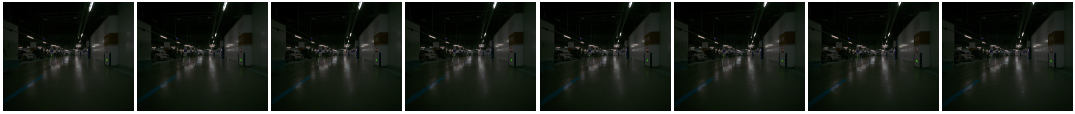

In [3]:
from hloc.visualization import plot_images, read_image

references = [p.relative_to(images/"images").as_posix() for p in (images/"images").iterdir()]
references.sort()

references = references[:173]


plot_images([read_image(images/"images"/r) for r in references][:8], dpi=25)

### 特征提取与匹配

对于提取到的图像进行特征提取，并在图像对之间进行特征匹配。

#### 特征提取

特征提取有许多算法可以使用，在这里我们选择DISK，在`hloc.extract_features`中定义了DISK算法的参数配置。

In [4]:
from hloc import extract_features

feature_conf = extract_features.confs['sift']

指定将提取到的特征输出到outputs路径下，进行特征提取。

In [5]:
features = outputs / 'features.h5'  # 特征输出文件，以hdf5的格式存储

extract_features.main(feature_conf, images/"images", image_list=references, feature_path=features)

[2023/08/07 11:24:30 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'dog'},
 'output': 'feats-sift',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
100%|██████████| 173/173 [01:14<00:00,  2.32it/s]
[2023/08/07 11:25:44 hloc INFO] Finished exporting features.


PosixPath('outputs/parking/features.h5')

#### 图像配对

hloc包中提供了许多配对的方式，其中`pairs_from_exhaustive`将所有图片进行两两配对，可以获得最稠密的结果。但当场景较大，所用到的图像数目较多时，特征匹配花费的时间不再能被接受，考虑到停车场采集的视频为序列信息，因此编写了`pairs_from_seq`将特征匹配的图像对限制在一个序列window中，其中的参数`window_size`指定了当前帧至于前后的$\frac{window\_size-1}{2}$张进行匹配。

使用`sfm_pairs`指定图像配对的输出路径，调用函数执行配对。

In [6]:
from hloc import pairs_from_seq, pairs_from_exhaustive

sfm_pairs = outputs / 'pairs-sfm.txt'
# pairs_from_exhaustive.main(sfm_pairs, image_list=references)
pairs_from_seq.main(sfm_pairs, image_list=references, window_size=51)

[2023/08/07 11:25:44 hloc INFO] Found 4000 pairs.


#### 特征匹配

前一步得到了一系列图像对，我们需要对于每一对图像进行特征匹配，算法采用lightglue。

使用`matches`指定输出路径，调用函数进行特征匹配。

In [7]:
from hloc import match_features

matches = outputs / 'matches.h5'
matcher_conf = match_features.confs['disk+lightglue']
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2023/08/07 11:25:44 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████| 4000/4000 [01:17<00:00, 51.31it/s]
[2023/08/07 11:27:03 hloc INFO] Finished exporting matches.


PosixPath('outputs/parking/matches.h5')

### 模型重建

基于之前得到的结果重建模型，使用`sfm_dir`指定构建模型的输出路径。

In [8]:
from hloc import reconstruction

sfm_dir = outputs / "sfm"

model = reconstruction.main(sfm_dir, images/"images", sfm_pairs, features, matches, image_list=references)

[2023/08/07 11:27:03 hloc WARNING] The database already exists, deleting it.
[2023/08/07 11:27:03 hloc INFO] Creating an empty database...
[2023/08/07 11:27:03 hloc INFO] Importing images into the database...
[2023/08/07 11:27:18 hloc INFO] Importing features into the database...
100%|██████████| 173/173 [00:00<00:00, 2602.59it/s]
[2023/08/07 11:27:18 hloc INFO] Importing matches into the database...
100%|██████████| 4000/4000 [00:02<00:00, 1971.21it/s]
[2023/08/07 11:27:20 hloc INFO] Performing geometric verification of the matches...
[2023/08/07 11:27:20 hloc INFO] Running 3D reconstruction...
[2023/08/07 11:27:20 hloc ERROR] Could not reconstruct any model!


上面得到的`model`就是colmap重建出的模型，对其进行三维可视化。

In [9]:
from hloc.utils import viz_3d

fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

AttributeError: 'NoneType' object has no attribute 'compute_bounding_box'

展示输入图像的特征点是否用于模型的重建，其中红色表示未使用，蓝色表示这些点被用于模型构建。

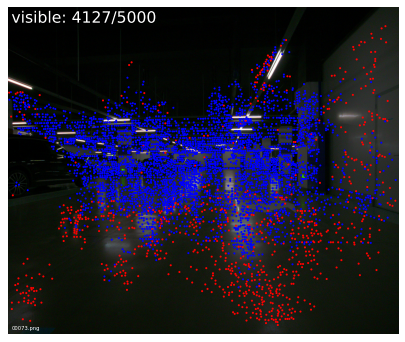

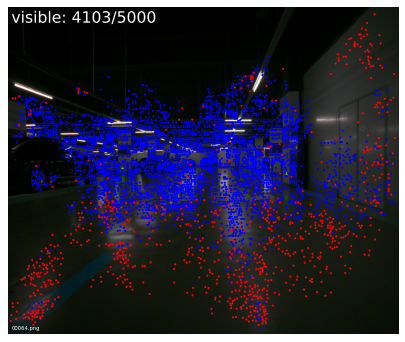

In [ ]:
from hloc import visualization

visualization.visualize_sfm_2d(model, images/"images", color_by='visibility', n=2)

## 定位

In [ ]:
model

NameError: name 'model' is not defined